In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from model import setup, visuals, balance_calcs, performance

# Part 1: Setting up the Conowingo system model

## 1.1 Defining a reservoir 

First we download the relevant data from the spreadsheet.

In [3]:
# First we download the key data
key_parameters = pd.read_excel('data/Conowingo_data.xlsx', sheet_name='Reservoir characteristics')

# Access the DataFrame
display(key_parameters)

,Key parameter and unit,Value
0,Reservoir min storage (hm3),171.0000
1,Total volume (hm3),380.0000
2,Full lake area (ha),3600.0000
3,Nominal (full) head for hydropower (m),33.0708
4,Installed capacity (MW),548.0000
5,Maximal release (m3/s),1980.0000
6,Baltimore intake depth (m),5.1816
7,Chester intake depth (m),2.4384
8,Nuclear plant intake depth (m),1.5240


As we can see, a reservoir reservoir has many characteristics that need to be represented:
>*   How storage volume, surface area and height of water in the reservoir are related. This is important for any use dependent on the height of water in the lake, e.g., hydropower, recreation, but also withdrawing water from the reservoir: water is withdrawn from a physical pipe situated at a certain depth (depth being calculated from the water level when the reservoir lake is full).
>*   We need to know what water uses depend on the reservoir.


For this, we define a `Reservoir` them as an object in Python. This is why `model/setup.py` declares the class, then associated functions. **Look up the `class Reservoir` part of `model/setup.py` to understand what it does. Use Gemini to help your understanding as needed.**

To note:
>* A key assumption here is that lake area increases linearly with the height of water in the lake.
>* Water balance will track storage volume so basic function convert that into area and height.
>* All units converted to **basic metric units (m, m2, m3)**. Let's do this now. 

In [5]:
full_lake_area =  key_parameters.iloc[2, key_parameters.columns.get_loc('Value')] * 100**2
full_lake_volume = key_parameters.iloc[1, key_parameters.columns.get_loc('Value')] * 100**3

Let us create a reservoir object with specified values.

In [7]:
# Create a reservoir object with the specified values
conowingo = setup.Reservoir("Conowingo", full_lake_area, full_lake_volume)

# Print characteristics of reservoir object
print(conowingo.__dict__)

{'name': 'Conowingo', 'full_lake_area': 36000000.0, 'full_lake_volume': 380000000.0, 'total_lake_depth': 21.11111111111111, 'initial_storage': 342000000.0, 'dead_storage': 0, 'hydropower_plant': None, 'demand_on_site': [], 'demand_downstream': []}


In [8]:
# Let us modify the reservoir to reflect actual dead storage
conowingo.dead_storage = key_parameters.iloc[0, key_parameters.columns.get_loc('Value')] * 100**3
print('Dead storage is now ' + str(int(conowingo.dead_storage  / 100**3)) + 'hm3.')

Dead storage is now 171hm3.


>* We also need to add the demands to the reservoir system, by declaring them using the methods introduced with the Reservoir class.
>* Note the Chester, Baltimore and nuclear plant demands are extractions from the reservoir, whereas environmental flows are releases.

In [10]:
conowingo.add_downstream_demand(setup.Demand(name='Environmental'))
conowingo.add_on_site_demand(setup.Demand(name='Baltimore'))
conowingo.add_on_site_demand(setup.Demand(name='Chester'))
conowingo.add_on_site_demand(setup.Demand(name='Nuclear plant'))

# Check result
print('List of demands directly withdrawing water from the reservoir:')
for i in range(len(conowingo.demand_on_site)):
    print(str(i+1) + ') ' + conowingo.demand_on_site[i].name)
print('\nList of demands downstream of the reservoir:')
for i in range(len(conowingo.demand_downstream)):
    print(str(i+1) + ') ' + conowingo.demand_downstream[i].name)

List of demands directly withdrawing water from the reservoir:
1) Baltimore
2) Chester
3) Nuclear plant

List of demands downstream of the reservoir:
1) Environmental


>* **Now we have a fully defined system, and we need to add water to it!**

## 1.2 Inflow and demand data

>* To run the water balance, we need inflow and demand data for our reservoir.

Let us first download the inflow data. Note that we make the first column the index.

In [12]:
inflow_data = pd.read_excel('data/Conowingo_data.xlsx', sheet_name='Flow data', index_col=0)
display(inflow_data.head(5))

,Susquehanna River Inflow (cfs),Lateral Inflow (cfs)
Date,,
1932-01-01,19500,172
1932-01-02,21400,1148
1932-01-03,25900,897
1932-01-04,28600,501
1932-01-05,27200,359


>* Demand data needs to be summed into a **total demand** column, and data needs to be converted to m3 / day. See Tutorial 1 for details.
>* Method `extract_flows` in `model/setup.py` will handle this for you.

Let us now download the demand data.

In [14]:
demand_data = pd.read_excel('data/Conowingo_data.xlsx', sheet_name='Demands')
display(demand_data)

,Month,Baltimore city (cfs),Chester city (cfs),Peach Bottom Nuclear Power Plant (cfs),Minimum environmental flows (cfs)
0,January,464,52,22,3500
1,February,464,55,20,3500
2,March,464,50,24,3500
3,April,464,47,29,10000
4,May,464,52,35,7500
5,June,464,54,41,5000
6,July,464,53,42,5000
7,August,464,54,40,5000
8,September,464,53,32,4200
9,October,464,51,24,3500


Now we need to add these demands to the water balance. Two key things to consider here, 
>1. Demands need to be expressed for each day over 70 years.
>2. We must use SI units!

>* Method `extract_flows` in `model/setup.py` will also handle this for you! Therefore, let us now **initialise the water balance**.

In [16]:
water_balance = setup.extract_flows(reservoir=conowingo)

display(water_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s)
Date,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963
...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963


# Part 2: Water balance dynamics

## 2.1 Dynamics over a single time step

Let us model inflows and releases (see slides 2 and 3 from tutorial slides). In practice, here we assume that:

1.   The ecological demand is served first (if possible).
2.   Other demands take water directly from the reservoir in the limit of what remains.
3.   Then excess water is spilled and added to the releases.

**This is called the standard operating policy (SOP) for water supply, where all water that does not meet a demand is kept in the reservoir unless it is full.**

>* **Question 1. What happens to the `water_available` variable through the `single_step` method?**
>* **Question 2. What is the role of minimum (or dead) storage?**

In [18]:
def single_step(reservoir, storage_beg, inflows, site_demand, downstream_demand):

    '''
    Note all in m3.
    :param reservoir: Object of the Reservoir class
    :param storage_beg: Initial storage at the beginning of the time step (m3)
    :param inflows: Inflows over the time step (m3)
    :param site_demand: Demand for withdrawal from reservoir over the time step (m3)
    :param downstream_demand: Demand for release for downstream use over the time step (m3)
    :return: storage_end (end of time step storage, m3)
    :return: release (amount of water released over time step, m3)
    :return: withdrawals (to meet demand over time step at reservoir, m3)
    '''

    # Compute water availability, accounting for dead storage (volume units)
    water_available = storage_beg - reservoir.dead_storage + inflows

    # Release for downstream demand (volumetric rate)
    release = np.min([water_available, downstream_demand])

    # Update water availability
    water_available = water_available - release

    # Withdrawals from the reservoir
    withdrawals = np.min([water_available, site_demand])

   # Update water availability
    water_available = water_available - withdrawals

    # Check if reservoir is over full
    if water_available + reservoir.dead_storage > reservoir.full_lake_volume:
        # Lake is full
        storage_end = reservoir.full_lake_volume
        # Excess storage is spilled
        release = release + (water_available + reservoir.dead_storage - reservoir.full_lake_volume)
    else:
        # Lake is not full so water availability determines new storage
        storage_end = water_available + reservoir.dead_storage

    return storage_end, release, withdrawals

**We can test this function in three cases, (1) not enough water, (2) enough water, (3) too much water.**

Note the time step is not specified, so we can test with arbitrary amounts of water and numbers!

>* So we call the function and check that the answer is what we would expect!
>* **Question 3. Below is a test for case 2 (the easiest), can you do the same for cases 1 and 3?**

In [20]:
# Inputs
storage_beg=0.8*conowingo.full_lake_volume
inflows=0.2*conowingo.full_lake_volume
site_demand=0.1*conowingo.full_lake_volume
downstream_demand=0.2*conowingo.full_lake_volume

# Call the function
x = single_step(conowingo, storage_beg, inflows, site_demand, downstream_demand)

# Examine results
print('At the end of the time step, reservoir is ' + str(int(x[0] / conowingo.full_lake_volume*100)) + '% full.')
print('At the end of the time step, releases meet ' + str(int(x[1] / downstream_demand * 100)) + '% of downstream demand.')
print('These releases correspond to '+ str(int(x[1] / conowingo.full_lake_volume*100)) + '% of total storage volume.')
print('At the end of the time step, withdrawals directly from the reservoir meet ' + str(int(x[2] / site_demand * 100)) + '% of demand.')
print('These withdrawals correspond to '+ str(int(x[2] / conowingo.full_lake_volume*100)) + '% of total storage volume.')

At the end of the time step, reservoir is 70% full.
At the end of the time step, releases meet 100% of downstream demand.
These releases correspond to 20% of total storage volume.
At the end of the time step, withdrawals directly from the reservoir meet 100% of demand.
These withdrawals correspond to 10% of total storage volume.


## 2.2 Water balance dynamics over time

This is a loop on days during the time frame of the simulation. At the heart is the one-step water balance.
**Mind the units: everything needs to be expressed in the same units (volume is easiest).**

This function has three main phases, and **you do not need to understand all the details here**:
1. A preparation phase where quantities are defined, and pandas DataFrames are put in a format that favours faster computation (numpy arrays).
2. A main loop using the single-step water balance function.
3. Resulting numpy vectors are written into the water balance DataFrame.

>* **Question 4. Can you spot the loop?**

In [22]:
def basic_water_balance(reservoir, water_flows):

  '''
  This function performs the water balance. Arguments are:
        reservoir: an instance of the Reservoir class
        water_flows: a pandas DataFrame that must contain inflows and demands.
  The function returns an updated water_flows DataFrame.
  '''

  # Local variable: number of time steps
  t_total = len(water_flows)

  # Local variable: number of seconds in a day
  n_sec = 86400

  # For computing efficiency: convert flows to numpy arrays outside of time loop

  # Inflows (in m3)
  inflows = water_flows['Total inflows (m3/s)'].to_numpy() * n_sec

  # Total downstream demand (in m3)
  downstream_demands = np.zeros(len(water_flows))
  for i in range(len(reservoir.demand_downstream)):
      # Get column with that demand
      demand_col = ([col for col in water_flows.columns if reservoir.demand_downstream[i].name in col])
      # Add this demand to total demand
      downstream_demands = downstream_demands + water_flows.loc[:, demand_col[0]].to_numpy()
  downstream_demands = downstream_demands * n_sec  # conversion to m3

  # Total at-site demands (in m3)
  at_site_demands = np.zeros(len(water_flows))
  for i in range(len(reservoir.demand_on_site)):
     # Get column with that demand
     demand_col = ([col for col in water_flows.columns if reservoir.demand_on_site[i].name in col])
     at_site_demands = at_site_demands + water_flows.loc[water_flows.index, demand_col[0]].to_numpy()
  at_site_demands = at_site_demands * n_sec  # conversion to m3

  # Initialise outputs
  # Storage needs to account for initial storage
  storage = np.zeros(t_total + 1)
  storage[0] = reservoir.initial_storage
  # Initialise at-site withdrawals and release as water balance components
  withdrawals = np.zeros(t_total)
  release = np.zeros(t_total)

  # Main loop
  for t in range(t_total):

    wb_out = single_step(reservoir, storage[t], inflows[t], at_site_demands[t], downstream_demands[t])
    storage[t+1] = wb_out[0]
    release[t] = wb_out[1]
    withdrawals[t] = wb_out[2]

  # Insert data into water balance (mind the flow rates conversions back into m3/s)
  water_flows['Withdrawals (m3/s)'] = withdrawals / n_sec
  water_flows['Release (m3/s)'] = release / n_sec
  water_flows['Storage (m3)'] = storage[1:]

  return water_flows


Now we call this water balance function for our case-study!

In [24]:
basic_water_balance(conowingo, water_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963,15.234463,101.999728,380000000.0
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963,15.234463,623.253793,380000000.0
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963,15.234463,743.572075,380000000.0
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963,15.234463,808.814089,380000000.0
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963,15.234463,765.149512,380000000.0
...,...,...,...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963,15.234463,760.732084,380000000.0
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963,15.234463,701.295023,380000000.0
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963,15.234463,653.128067,380000000.0


As in Tutorial 1, we can visualise results. Let us plot reservoir storage over time using a method from file `src/visuals.py`.

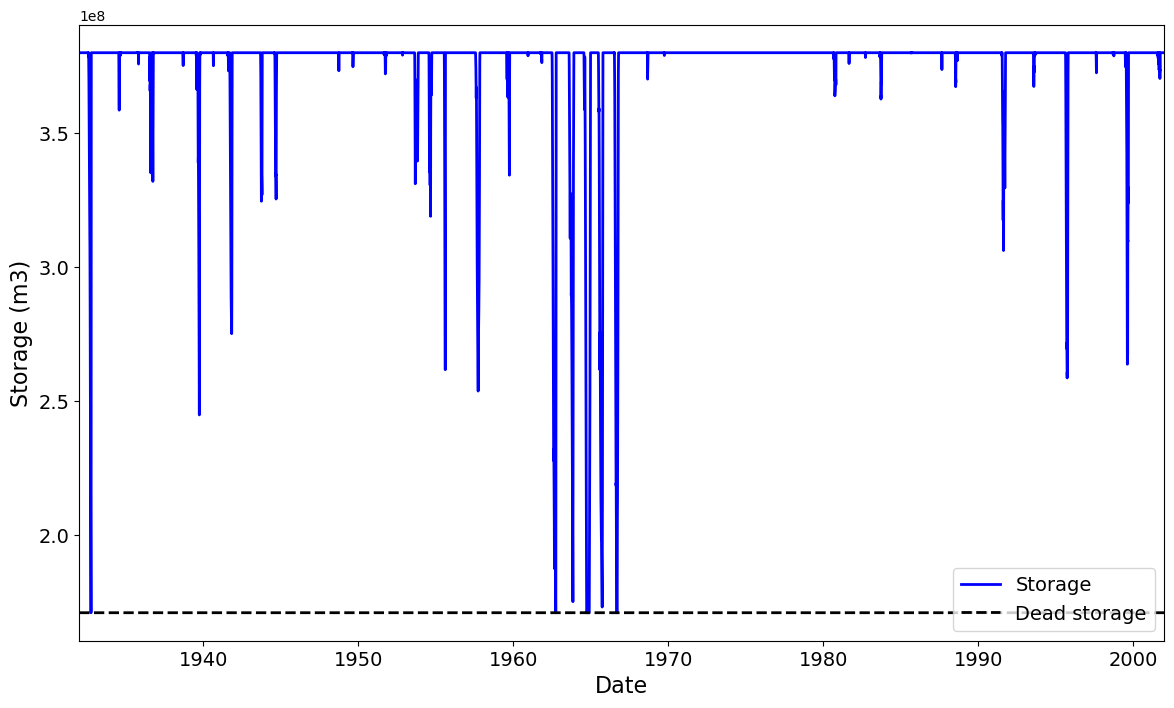

In [26]:
fig =visuals.storage_timeseries(reservoir=conowingo,
                                balance=water_balance)

>* **Question 5. What do you notice about storage: overall level, any dry period?**

We can zoom in on any period of interest, for instance in the 1960s.

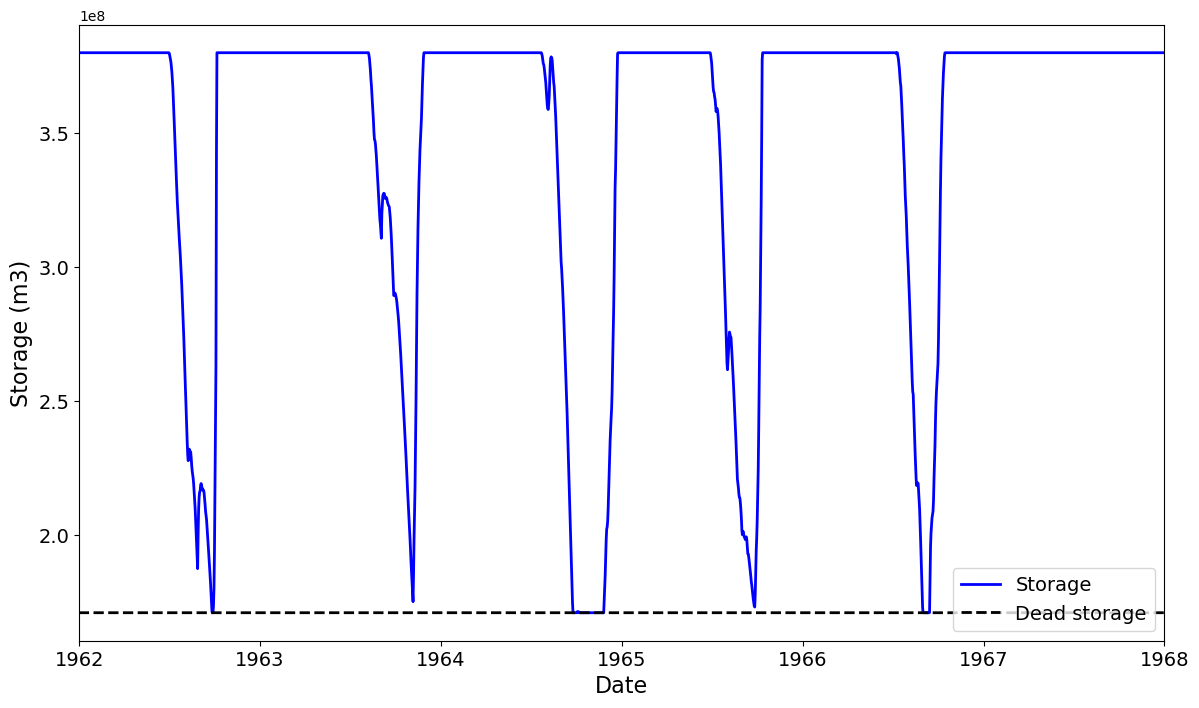

In [28]:
fig =visuals.storage_timeseries(reservoir=conowingo,
                                balance=water_balance,
                                first_date=datetime.date(1962,1,1),
                                last_date=datetime.date(1968,1,1)
                               )

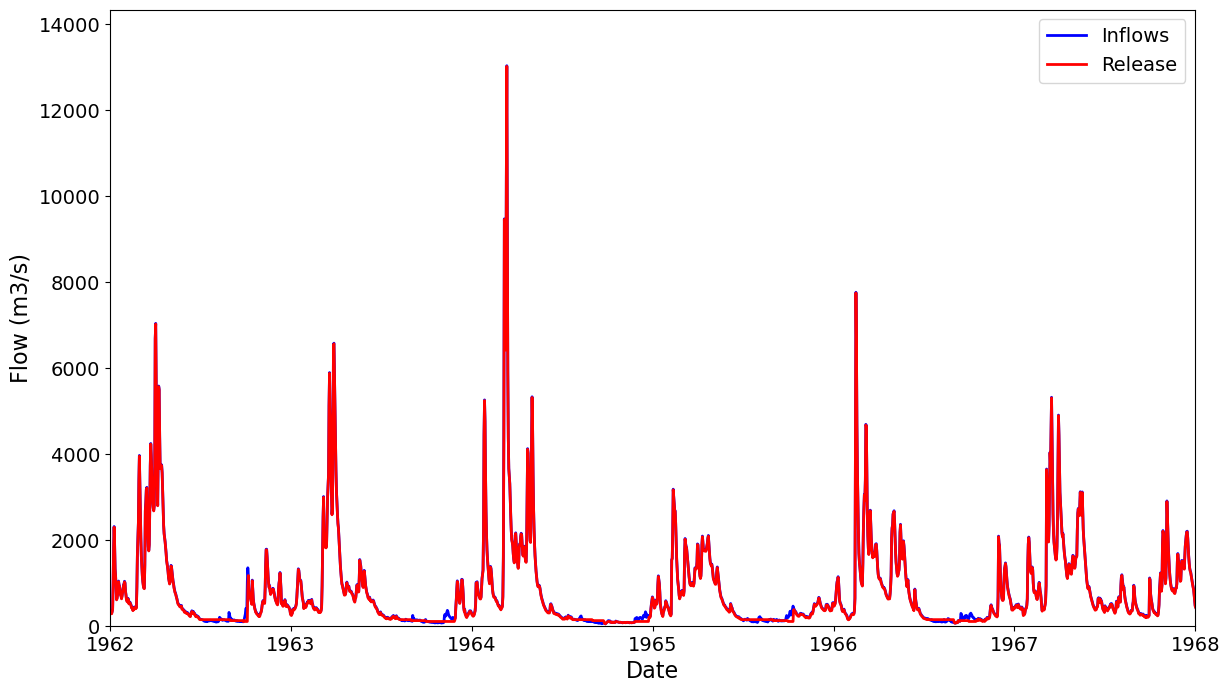

In [29]:
# What happens to inflows and release during that period?
fig = visuals.compare_flow_timeseries(reference=water_balance['Total inflows (m3/s)'],
                                      alternative=water_balance['Release (m3/s)'],
                                      labels=['Inflows', 'Release'],
                                      y_axis_label='Flow (m3/s)',
                                      first_date=datetime.date(1962,1,1),
                                      last_date=datetime.date(1968,1,1))                                

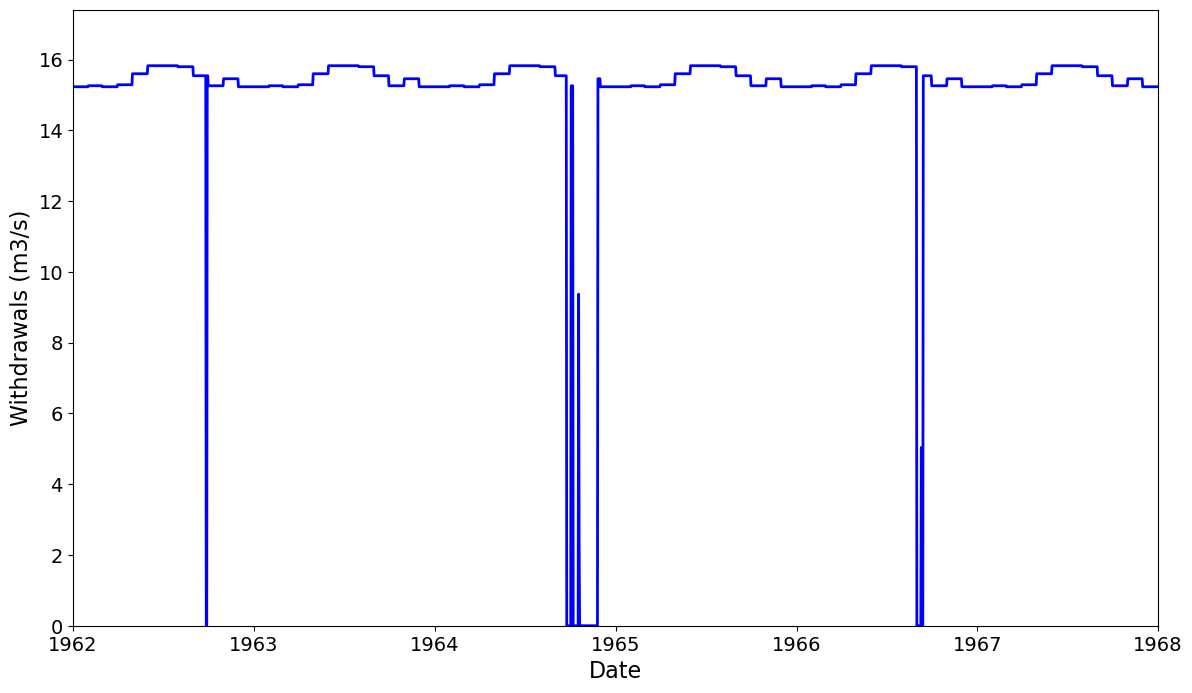

In [30]:
# And what about the withdrawals from the reservoir?
fig = visuals.flow_timeseries(time_series=water_balance['Withdrawals (m3/s)'],
                              first_date=datetime.date(1962,1,1),
                              last_date=datetime.date(1968,1,1)) 

Some questions to better understand the water balance dynamics:

>* **Question 6. From the above figures and the water balance, when are withdrawals less than the demand?**
>* **Question 7. Are the withdrawals large compared with the average inflows?**
>* **Question 8. Can this reservoir store water from the wet season for the dry season?**


In [32]:
# Let's save these withdrawals for future reference
basic_withdrawals = pd.Series(water_balance['Withdrawals (m3/s)'])

# Part 3: More realistic water balance dynamics

>* Now we represent the fact that each withdrawal from the reservoir is at a given intake height (see the reservoir's key characteristics, as well as **tutorial slide 4**).
>* We need to **re-initiatlise the demands** from the reservoirs to add the intake heights to the demands.

In [34]:
# Re-initialise
conowingo.demand_downstream = []
conowingo.demand_on_site = []

# Add demands using Demand objects
conowingo.add_downstream_demand(setup.Demand('Environmental'))
conowingo.add_on_site_demand(setup.Demand('Baltimore', key_parameters.iloc[6, 1]))
conowingo.add_on_site_demand(setup.Demand('Chester', key_parameters.iloc[7, 1]))
conowingo.add_on_site_demand(setup.Demand('Nuclear plant', key_parameters.iloc[8, 1]))

We also need to remove **the results of the previous water balance**, i.e., columns for withdrawals, release, storage, from the water balance DataFrame.

In [36]:
water_balance.drop(['Release (m3/s)', 'Withdrawals (m3/s)', 'Storage (m3)'], axis=1, inplace=True)

# list the remaining columns
print(water_balance.columns)

Index(['Total inflows (m3/s)', 'Baltimore demand (m3/s)',
       'Chester demand (m3/s)', 'Nuclear plant demand (m3/s)',
       'Environmental demand (m3/s)'],
      dtype='object')


**And that is going to change how we conduct the water balance!** Let us update it:

In [38]:
water_balance = balance_calcs.sop_full(reservoir=conowingo,
                                       water_flows=water_balance)

display(water_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,101.999728,380000000.0
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,623.253793,380000000.0
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,743.572075,380000000.0
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,808.814089,380000000.0
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,765.149512,380000000.0
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,760.732084,380000000.0
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,701.295023,380000000.0
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,653.128067,380000000.0


>* **Question 9. How is the water balance conducted differently when accounting for intake depth?**

Hint: to help to answer this question, I recommed you feed to Google Gemini the single-step water balance without intakes (method `single_step` above) and the one with intakes (method `sop_single_step` from `model/balance_calcs.py`), and ask it to compare the two methods. **Asking AI to spot differences between documents and explain them is a good professional skill to have.**

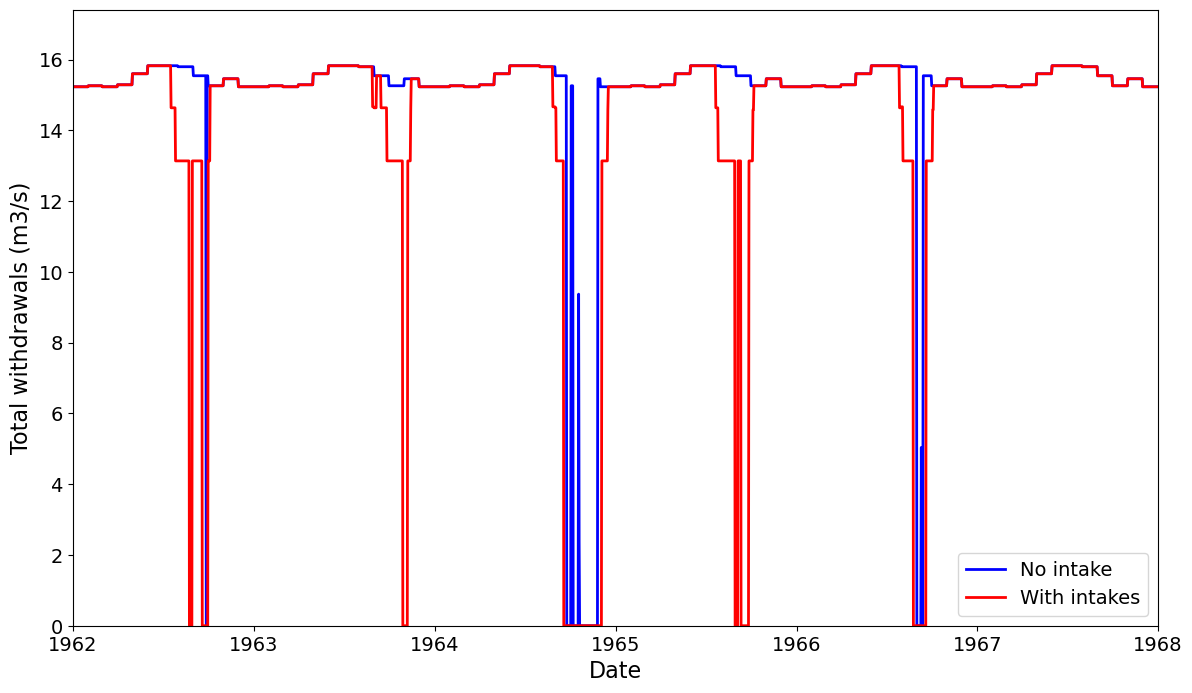

In [40]:
# How does this greater level of realism affect withdrawals from the reservoir?
fig = visuals.compare_flow_timeseries(reference=basic_withdrawals,
                                      alternative=water_balance['Withdrawals Baltimore (m3/s)'] + water_balance['Withdrawals Chester (m3/s)'] + water_balance['Withdrawals Nuclear plant (m3/s)'],
                                      labels=['No intake', 'With intakes'],
                                      y_axis_label='Total withdrawals (m3/s)',
                                      first_date=datetime.date(1962,1,1),
                                      last_date=datetime.date(1968,1,1))

>* **Question 10. Did withdrawals increase or decrease when we accounted for intake depth, and why?**

# Part 4: Perfromance metrics

Management objectives are as follows:
1) Produce hydropower
2) Meet environmental flows
3) Meet domestic and industrial demands
4) Avoid excessive flooding that would require evacuating the downstream town of “Port Deposit” (15,000 m3/s)

First, we will explore objective (1), and we will then focus on the other objectives. For these objectives, we will compare the water flows / levels versus a threshold, and use the R-R-V indicators defined in the lecture (reliability / resilience / vulnerability).


## 4.1 - Hydropower

For Conowingo Dam, key parameters of the hydropower plant can be found in the **"Reservoir characteristics"** part of the spreadsheet.

In [43]:
# Define hydropower plant characteristics from file
nominal_head = key_parameters.iloc[3, key_parameters.columns.get_loc('Value')]
installed_capacity = key_parameters.iloc[4, key_parameters.columns.get_loc('Value')]
max_release = key_parameters.iloc[5, key_parameters.columns.get_loc('Value')]
conowingo.hydropower_plant = setup.Hydropower(installed_capacity, nominal_head, max_release)

In [44]:
# Compute daily hydropower 
hydropower_daily = conowingo.daily_production(water_balance)

In [45]:
# First the headline number: average over 70 years (GWh)
print('Annual average hydropower production at Conowingo is ' + "{:.0f}".format(hydropower_daily.sum() / 70 / 1000) + ' GWh')

Annual average hydropower production at Conowingo is 2064 GWh


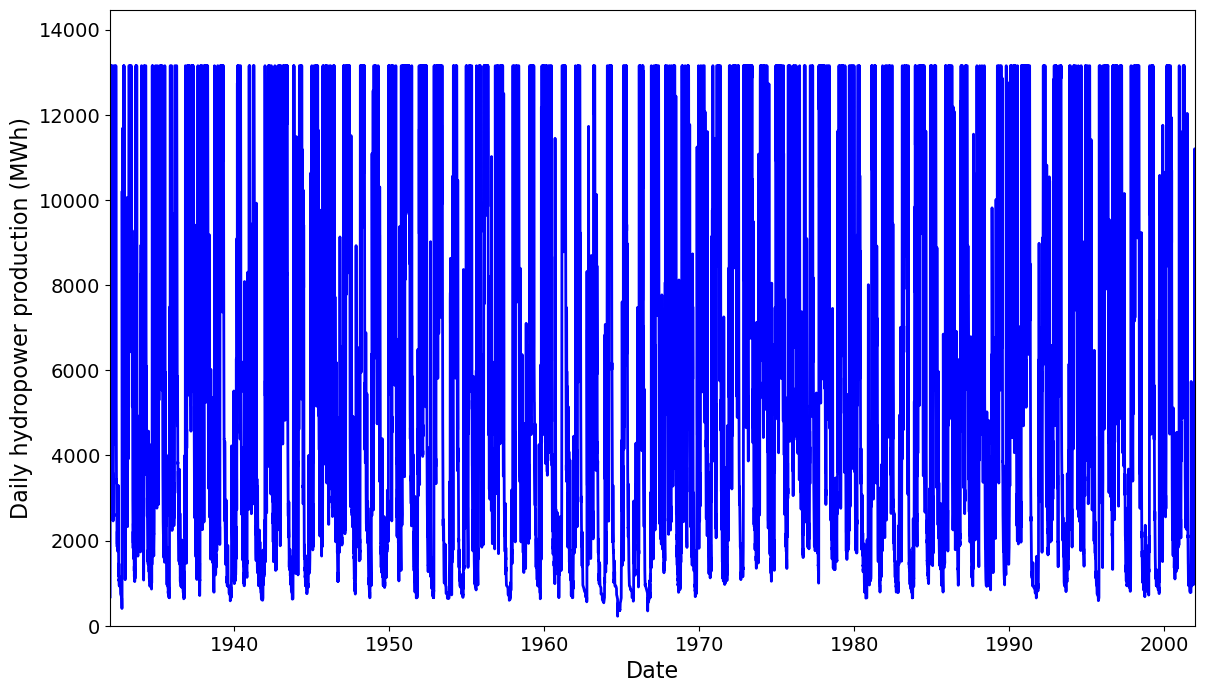

In [46]:
# Now plot it
fig = visuals.flow_timeseries(time_series=hydropower_daily) 

This is **not** a very helpful visual, and aggregation to annual data will certainly be helpful.

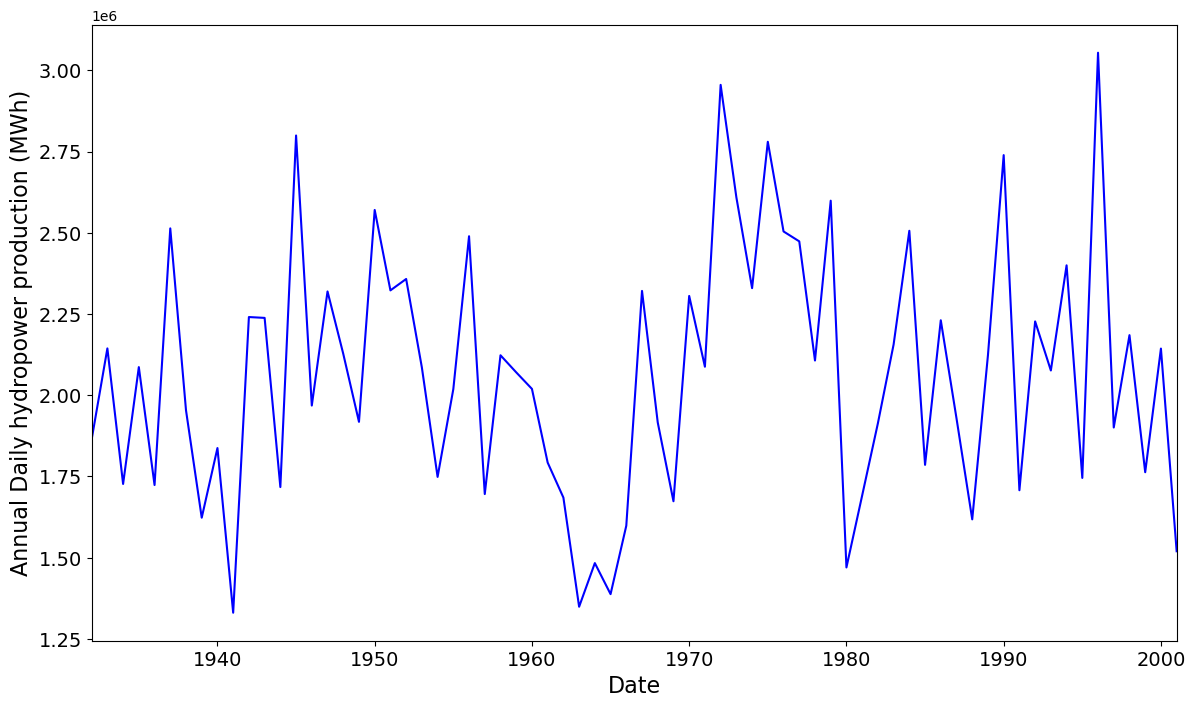

In [48]:
fig = visuals.annual_average(daily_data=hydropower_daily,
                             data_label=hydropower_daily.name)            

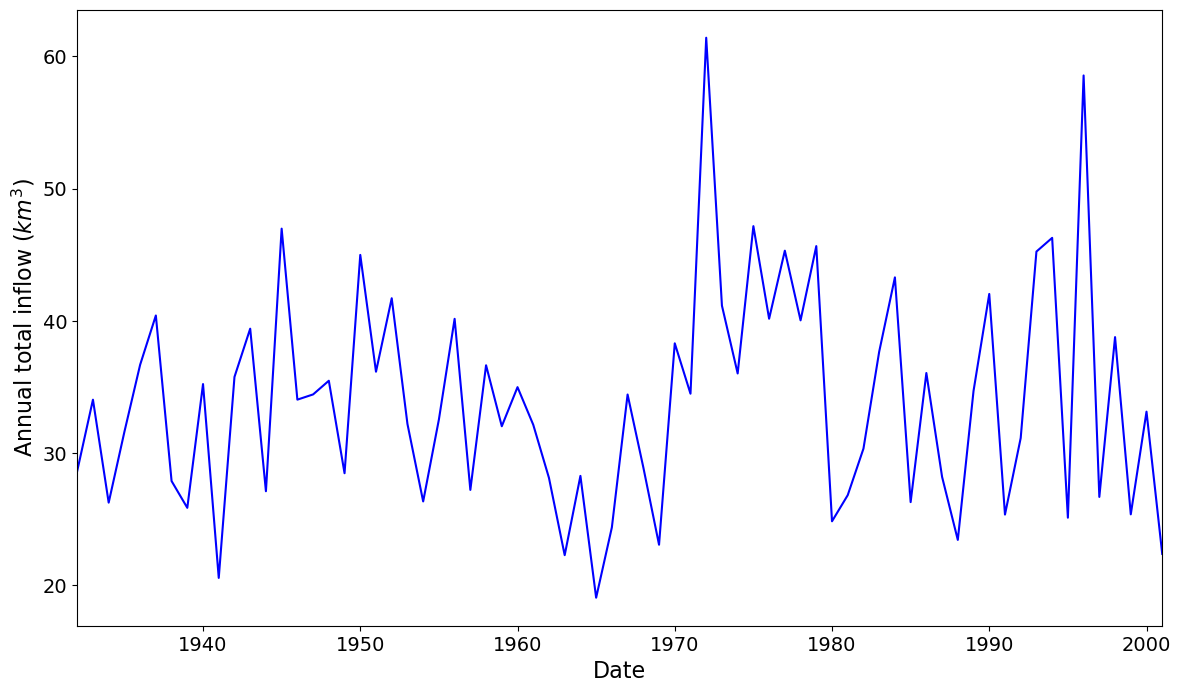

In [49]:
# let us compare with annual average flows.
fig = visuals.annual_average(daily_data=pd.Series(water_balance['Total inflows (m3/s)']) * 86400/1E9, 
                             data_label='total inflow ($km^3$)')

>* **Question 11. What can we say about the correlation between inflows and hydropower production?**


## 4.2 - R-R-V indicators for demand

Let us now introduce a function to compute the R-R-V performance metrics introduced in the lecture.

In [51]:
# Application to all four Conowingo demands
metrics = pd.concat([performance.rrv_indicators(time_series=water_balance['Withdrawals Baltimore (m3/s)'].to_numpy(), 
                                                dynamic_threshold=water_balance['Baltimore demand (m3/s)'].to_numpy(), 
                                                above_desirable=True, 
                                                name='Baltimore'),
                     performance.rrv_indicators(water_balance['Withdrawals Chester (m3/s)'].to_numpy(), 
                                                water_balance['Chester demand (m3/s)'].to_numpy(), True, 'Chester'),
                     performance.rrv_indicators(water_balance['Withdrawals Nuclear plant (m3/s)'].to_numpy(), 
                                                water_balance['Nuclear plant demand (m3/s)'].to_numpy(), True, 'Nuclear'),
                     performance.rrv_indicators(water_balance['Release (m3/s)'].to_numpy(), 
                                                water_balance['Environmental demand (m3/s)'].to_numpy(), True, 'Env. flows')],
                     axis=0, ignore_index=True)

print('Performance metrics for demands are:\n')
display(metrics)

Performance metrics for demands are:



,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count
0,Baltimore,0.993547,0.048485,100%,8
1,Chester,0.980327,0.023857,100%,12
2,Nuclear,0.974343,0.025915,100%,17
3,Env. flows,0.997614,0.098361,34%,6


In [52]:
# Compare with the water balance without modelling the intakes
withdrawal_demand = water_balance['Baltimore demand (m3/s)'] + water_balance['Chester demand (m3/s)'] + water_balance['Nuclear plant demand (m3/s)']
no_intake_metrics = pd.concat([performance.rrv_indicators(time_series=basic_withdrawals.to_numpy(), 
                                                          dynamic_threshold=withdrawal_demand.to_numpy(),
                                                          above_desirable=True,
                                                          name='Withdrawals'),
                               performance.rrv_indicators(water_balance['Release (m3/s)'].to_numpy(), 
                                                          water_balance['Environmental demand (m3/s)'].to_numpy(), True, 'Env. flows')],
                              axis=0, ignore_index=True)

print('Without intakes, performance metrics would be:\n')
display(no_intake_metrics)

Without intakes, performance metrics would be:



,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count
0,Withdrawals,0.99691,0.063291,100%,5
1,Env. flows,0.997614,0.098361,34%,6


>* **Question 12. Do results confirm previous observations on the need to model intakes?**
>* **Question 13. Here we measure vulnerability as a percentage of demand not met. Why?**

## 4.3 - Flooding

In [54]:
# Same for flooding
flooding_metrics = performance.rrv_indicators(time_series=water_balance['Release (m3/s)'].to_numpy(), 
                                              dynamic_threshold=15000*np.ones(len(water_balance)), 
                                              above_desirable=False, 
                                              name='Flooding')

metrics = pd.concat([metrics, flooding_metrics], axis=0, ignore_index=True)

print('Performance metrics including demands and flooding are:\n')
display(metrics)

Performance metrics including demands and flooding are:



,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count
0,Baltimore,0.993547,0.048485,100%,8
1,Chester,0.980327,0.023857,100%,12
2,Nuclear,0.974343,0.025915,100%,17
3,Env. flows,0.997614,0.098361,34%,6
4,Flooding,0.999687,0.5,36%,4


>* **Question 14. Compute how long it takes a flood at the flooding threshold to completely fill Conowingo, and use this to comment on the reliability, resilience and vulnerability for the flooding objective. In particular, can we use different operating policies to avoid flooding the town downstream of Conowingo (Port Deposit)?**

>* **Question 15. Which objectives do you feel the chosen operating policy favours? Why?**